In [1]:
import re
import json
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import pomegranate as pg
from collections import Counter
from scipy.stats import chi2_contingency
import shap
import xgboost
import matplotlib.pylab as pl

%config InlineBackend.figure_format = 'svg'
topk_paths = 30
num_states = 15
num_clusters = 150
agent_percent = 0.15
callback_thresh = 2
cluster_parent_dir = '../tmobile/cluster_assignment/bert-base-uncased_mlm-lemax-merge-num2'
label_path = '../tmobile/metadata/labels5.csv.gz'
ndf_path = '/g/ssli/data/tmcalls/roylu/stats_data/ndf2.pkl'
model_path = f'{cluster_parent_dir}/sshmm/agent_{num_clusters:03}/models/sshmm_{num_states:03}.json'
state_seq_dir = f'{cluster_parent_dir}/state_sequence/agent_{num_clusters:03}/state_{num_states:03}'
msa_path = f'../tmobile/agent_info/msa_{agent_percent}.csv'
lsa_path = f'../tmobile/agent_info/lsa_{agent_percent}.csv'

In [47]:
def collapse(x):
    chrs = ''.join([chr(int(xx)+97) for xx in x.strip().split(',')])
    collapsed_chrs = re.sub(r'(.)\1+', r'\1', chrs)
    collapsed_state_seq = ','.join([idx2state[ord(c)-97] for c in collapsed_chrs])
    return collapsed_state_seq

def convert_to_named_states(x):
    x = x.split(',')
    x = [idx2state[int(xx)] for xx in x]
    return ','.join(x)

def bistate_duration(original, collapsed):
    cnt = {0: 1}
    c_idx = 0
    original = original.split(',')
    for o_idx in range(1, len(original)):
        if original[o_idx-1] != original[o_idx]:
            c_idx += 1
        cnt[c_idx] = cnt.get(c_idx, 0) + 1
        
    duration = {}
    collapsed = collapsed.split(',')
    total = len(original) + 2 # start and end states
   
    # bigram
    for i in range(len(collapsed)-1):
        key = f'{collapsed[i]},{collapsed[i+1]}'
        duration[key] = (cnt[i] + cnt[i+1]) / total
        
    key = f'Start,{collapsed[0]}'
    duration[key] = 1 / total
    key = f'{collapsed[-1]},End'
    duration[key] = 1 / total
    
    # Unigram
    #for i in range(len(collapsed)):
    #    key = collapsed[i]
    #    duration[key] = 1 / total
    
    return duration

def unistate_duration(original):
    original = original.split(',')
    cnt = Counter(original)
    
    duration = {}
    for state, c in cnt.items():
        duration[state] = c / len(original)
    
    return duration
        

In [58]:
with open(model_path, 'r') as f:
    hmm = pg.HiddenMarkovModel.from_json(json.load(f))
    
idx2state = {}
for i, s in enumerate(hmm.states):
    idx2state[i] = s.name.split('<-')[0].strip()
    
assert len(idx2state) - 2 == num_states

label_df = pd.read_csv(label_path, compression='gzip', sep='|')
label_df = label_df[['sourcemediaid', 'split', 'C']]
label_df = label_df[label_df['C'] != 'skip']
label_df['grouped_C'] = label_df['C'].map({'sc': 'cn', 'c2':'c2', 'cn': 'cn'})
    
print(f'# states = {len(idx2state)-2}')
print(f'# clusters = {num_clusters}')

split2seq_df = {}
for split in ['train', 'dev', 'test']:
    print(f'Load {split} sequence dataframe')
    df_path = f'{state_seq_dir}/agent_{split}.csv'
    seq_df = pd.read_csv(df_path, sep='|').rename(columns={'example_id': 'sourcemediaid'})
    seq_df['collapsed_state_sequence'] = seq_df['state_sequence'].apply(lambda x: collapse(x))
    seq_df['named_state_sequence'] = seq_df['state_sequence'].apply(lambda x: convert_to_named_states(x))
    seq_df['bistate_duration'] = seq_df.apply(lambda row: bistate_duration(row['named_state_sequence'], row['collapsed_state_sequence']), axis=1)
    seq_df['unistate_duration'] = seq_df['named_state_sequence'].apply(lambda x: unistate_duration(x))
    seq_df['join_state_duration'] = seq_df.apply(lambda row: {**row['bistate_duration'], **row['unistate_duration']}, axis=1)
    seq_df = seq_df.merge(label_df, on='sourcemediaid')
    split2seq_df[split] = seq_df

# states = 15
# clusters = 150
Load train sequence dataframe
Load dev sequence dataframe
Load test sequence dataframe


In [60]:
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
le = preprocessing.LabelEncoder()
dv = DictVectorizer()

map_state_indicator = True


#x_train = dv.fit_transform(split2seq_df['train']['bistate_duration'])
#y_train = le.fit_transform(split2seq_df['train']['grouped_C']) * -1 + 1
#x_test = dv.transform(split2seq_df['test']['bistate_duration'])
#y_test = le.transform(split2seq_df['test']['grouped_C']) * -1 + 1

x_train = dv.fit_transform(split2seq_df['train']['join_state_duration'])
y_train = le.fit_transform(split2seq_df['train']['grouped_C']) * -1 + 1
x_test = dv.transform(split2seq_df['test']['join_state_duration'])
y_test = le.transform(split2seq_df['test']['grouped_C']) * -1 + 1

if map_state_indicator:
    mask = x_train > 0
    x_train[mask] = 1
    mask = x_test > 0
    x_test[mask] = 1

#x_train = dv.fit_transform(split2seq_df['dev'].head(100)['bistate_duration'])
#
#y_train = le.fit_transform(split2seq_df['dev'].head(100)['grouped_C']) * -1 + 1 # reverse cb and ncb
#
#x_test = dv.transform(split2seq_df['test'].head(100)['bistate_duration'])
#
#y_test = le.transform(split2seq_df['test'].head(100)['grouped_C']) * -1 + 1

In [61]:
cols = [k for k, v in sorted(dv.vocabulary_.items(), key=lambda x: x[1])]
x_train = pd.DataFrame(x_train.toarray(), columns=cols)
x_test = pd.DataFrame(x_test.toarray(), columns=cols)

In [62]:
xgb_train = xgboost.DMatrix(x_train, label=y_train)
xgb_test = xgboost.DMatrix(x_test, label=y_test)

In [63]:
cnt = Counter(y_train)
estimate = cnt[0] / cnt[1]
print(cnt)
print(f'Estimate: {estimate:.3f}')

Counter({0: 513763, 1: 53061})
Estimate: 9.682


In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, auc

estimate=1

clf = xgboost.XGBClassifier(scale_pos_weight=estimate)
clf.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    eval_metric=['auc','error','logloss'],
    verbose=True,
)
y_pred = clf.predict_proba(x_test)
y_true = np.array(y_test)
y_scores = y_pred[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
print(f'test set roc_auc = {roc_auc}')

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[0]	validation_0-auc:0.62720	validation_0-error:0.09361	validation_0-logloss:0.52275	validation_1-auc:0.62044	validation_1-error:0.09312	validation_1-logloss:0.52248
[1]	validation_0-auc:0.63120	validation_0-error:0.09361	validation_0-logloss:0.43184	validation_1-auc:0.62408	validation_1-error:0.09313	validation_1-logloss:0.43166
[2]	validation_0-auc:0.63222	validation_0-error:0.09361	validation_0-logloss:0.37896	validation_1-auc:0.62487	validation_1-error:0.09313	validation_1-logloss:0.37876
[3]	validation_0-auc:0.63215	validation_0-error:0.09361	validation_0-logloss:0.34722	validation_1-auc:0.62479	validation_1-error:0.09312	validation_1-logloss:0.34696
[4]	validation_0-auc:0.63258	validation_0-error:0.09361	validation_0-logloss:0.32799	validation_1-auc:0.62503	validation_1-error:0.09312	validation_1-logloss:0.32781
[5]	validation_0-auc:0.63263	validation_0-error:0.09361	validation_0-logloss:0.31649	validation_1-auc:0.62504	validation_1-error:0.09312	validation_1-logloss:0.31632
[6]	

[50]	validation_0-auc:0.63439	validation_0-error:0.09360	validation_0-logloss:0.30029	validation_1-auc:0.62568	validation_1-error:0.09312	validation_1-logloss:0.30071
[51]	validation_0-auc:0.63439	validation_0-error:0.09360	validation_0-logloss:0.30029	validation_1-auc:0.62569	validation_1-error:0.09312	validation_1-logloss:0.30071
[52]	validation_0-auc:0.63440	validation_0-error:0.09360	validation_0-logloss:0.30031	validation_1-auc:0.62571	validation_1-error:0.09312	validation_1-logloss:0.30072
[53]	validation_0-auc:0.63442	validation_0-error:0.09360	validation_0-logloss:0.30030	validation_1-auc:0.62569	validation_1-error:0.09312	validation_1-logloss:0.30071
[54]	validation_0-auc:0.63442	validation_0-error:0.09360	validation_0-logloss:0.30030	validation_1-auc:0.62566	validation_1-error:0.09312	validation_1-logloss:0.30072
[55]	validation_0-auc:0.63443	validation_0-error:0.09360	validation_0-logloss:0.30029	validation_1-auc:0.62568	validation_1-error:0.09312	validation_1-logloss:0.3007

test set roc_auc = 0.6258614352518315


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


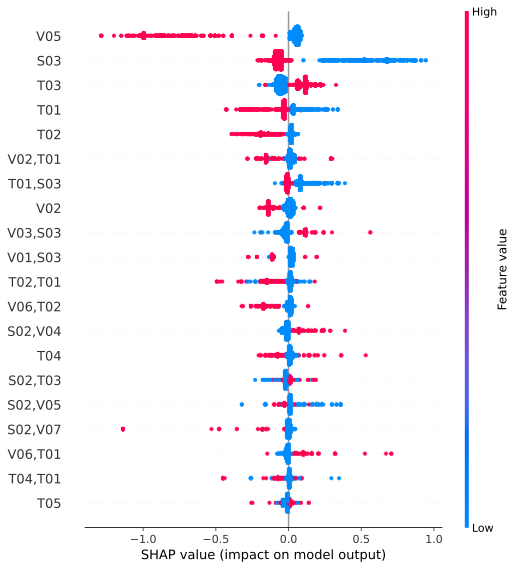

In [65]:
shap_values = shap.TreeExplainer(clf).shap_values(x_test)
shap.summary_plot(shap_values, x_test)

In [26]:
Counter(y_test)

Counter({1: 10446, 0: 101737})

In [34]:
num_plot_examples = 10000
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(x_test.iloc[:num_plot_examples,:])

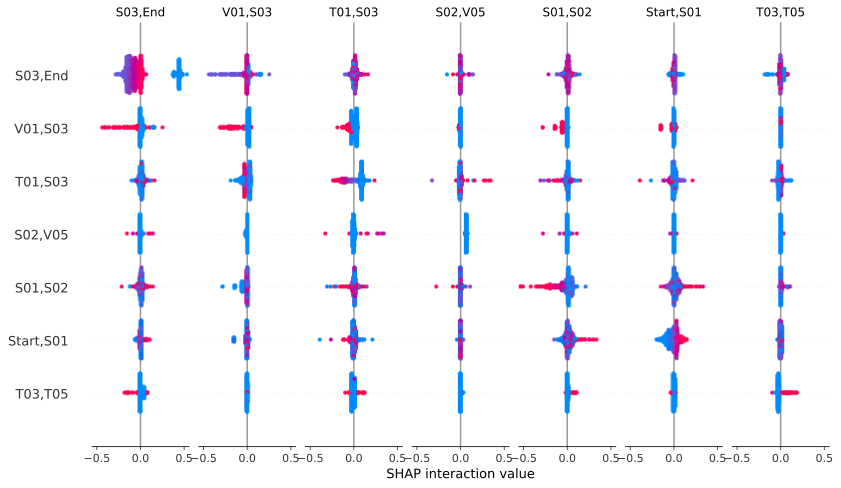

In [30]:
shap.summary_plot(shap_interaction_values, x_test.iloc[:2000,:])

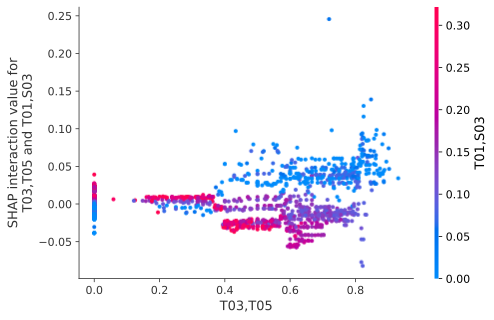

In [35]:
shap.dependence_plot(
    ("T03,T05", "T01,S03"),
    shap_interaction_values,
    x_test.iloc[:num_plot_examples,:],
)

In [22]:
print(Counter(y_test))

Counter({0: 101737, 1: 10446})


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
model = xgboost.XGBClassifier(scale_pos_weight=estimate)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % np.mean(scores))

In [348]:
# use validation set to choose # of trees
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(
    params,
    xgb_train,
    10000,
    evals=[(xgb_test, "test")],
    verbose_eval=1000,
)

[0]	test-logloss:0.30394


KeyboardInterrupt: 

In [320]:
y_pred = model_train.predict(xgb_test)

In [330]:
y_pred2 = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred2)
print(accuracy)

0.900724708734835


In [319]:
np.mean(y_test)

0.906884287280604

In [311]:
shap_values = shap.TreeExplainer(model_train).shap_values(x_test)
shap.summary_plot(shap_values, x_test)

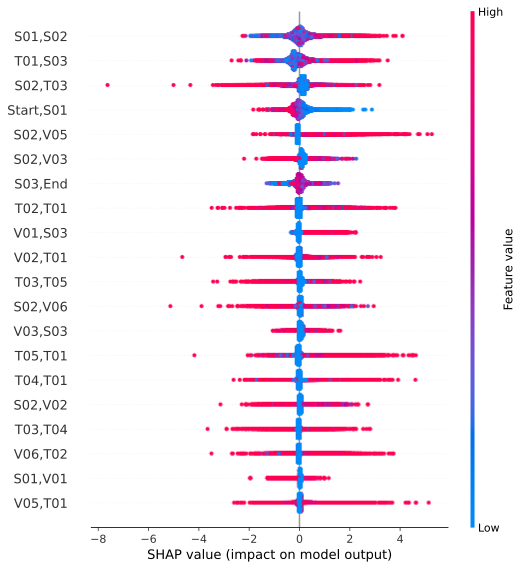